<a href='https://colab.research.google.com/github/gabri00/ML2-assignment/blob/main/assignment.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

# Machine Learning 2 for Robotics 

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Load dataset

In [2]:
dataset = pd.read_csv('dataset.csv')
print(dataset.shape)

(5456, 26)


#### Preprocessing

In [3]:
def init_dataset(dataset, target, test_perc=0.3):
    # Separate the dataset into features and target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Split the dataset 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc)

    # Standardize
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)

    return X_train_std, X_test_std, y_train, y_test

In [4]:
# Remove the id column
dataset = dataset.iloc[:, 1:]

X_train_std, X_test_std, y_train, y_test = init_dataset(dataset=dataset, target=dataset.columns[-1])

classes = np.unique(y_train)
class_labels = ['Forward', 'Slight-Right', 'Sharp-Right', 'Slight-Left']

print('Train set:\t', X_train_std.shape, '\nTest set:\t', X_test_std.shape)

Train set:	 (3819, 24) 
Test set:	 (1637, 24)


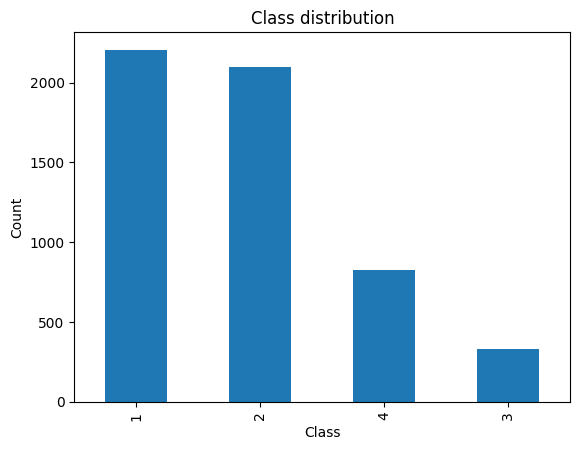

In [5]:
dataset['Class'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
plt.show()

#### Utility Functions

In [6]:
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Make predictions
def predict_model(model, X_test):
    return model.predict(X_test)

# Hyperparameter tuning
def fit_model_grid(model, X, y, param_grid, cv=5):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='balanced_accuracy',
        cv=cv,
        n_jobs=-1,
        verbose=3)

    h_param = grid.fit(X, y)

    return h_param.best_estimator_

def model_score(y_test, y_pred):
    # Accuracy scores
    acc_score = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced accuracy: {acc_score:.3f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
    disp.plot()
    plt.show()

    return acc_score

#### Logistic Regression

In [7]:
lr_best = fit_model_grid(
    LogisticRegression(max_iter=1000, n_jobs=-1),
    X_train_std,
    y_train,
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'solver': ['lbfgs', 'newton-cg'],
        'multi_class' : ['ovr', 'multinomial']
    }
)

y_pred_lr = predict_model(lr_best, X_test_std)

display(lr_best)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


LogisticRegression(C=10, max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='newton-cg')

Balanced accuracy: 0.646


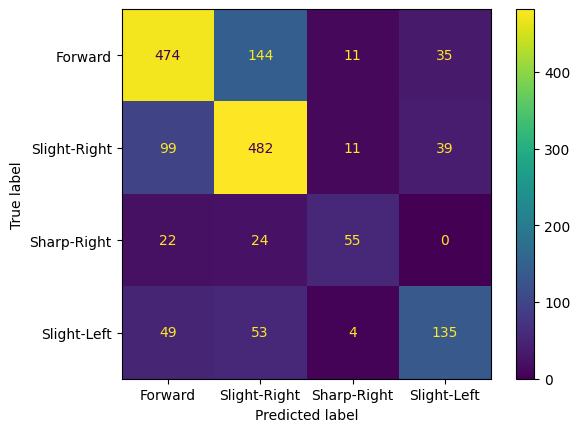

In [8]:
acc_score_lr = model_score(y_test, y_pred_lr)

#### Support Vector Machine

In [9]:
svm_best = fit_model_grid(
    SVC(),
    X_train_std,
    y_train,
    param_grid={
        'C': np.logspace(-4, 3, 4),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': np.logspace(-4, 3, 4)
    }
)

y_pred_svm = predict_model(svm_best, X_test_std)

display(svm_best)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


SVC(C=1000.0, gamma=0.021544346900318846)

Balanced accuracy: 0.899


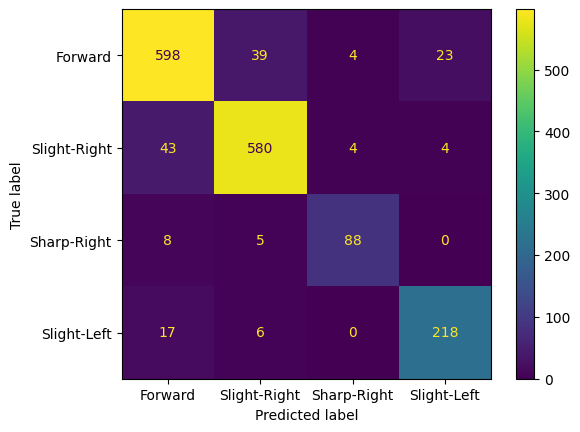

In [10]:
acc_score_svm = model_score(y_test, y_pred_svm)

#### Random Forest

In [11]:
forest_best = fit_model_grid(
    RandomForestClassifier(n_estimators=1000, n_jobs=-1),
    X_train_std,
    y_train,
    param_grid={
        'max_features': ['sqrt', 'log2'], 
        'max_depth': [10, 50, 100],
        'criterion' :['gini', 'entropy']
    }
)

y_pred_forest = predict_model(forest_best, X_test_std)

display(forest_best)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=1000,
                       n_jobs=-1)

Balanced accuracy: 0.994


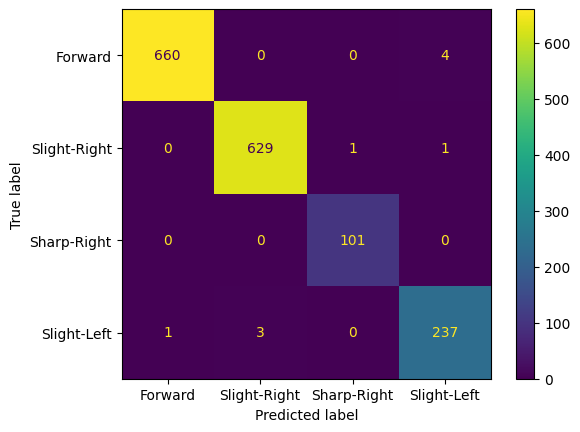

In [12]:
acc_score_forest = model_score(y_test, y_pred_forest)

#### Model comparison

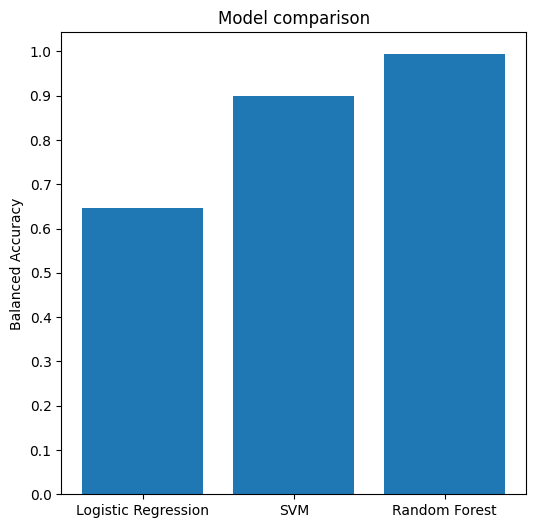

In [13]:
# Plot a comparison between the accuracy of the three models
fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(['Logistic Regression', 'SVM', 'Random Forest'], [acc_score_lr, acc_score_svm, acc_score_forest])
# Increase the y ticks
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Model comparison')
plt.show()

In [18]:
from sklearn.decomposition import PCA

def computePCA(data):    
    pca = PCA() # Compute PCA
    data_pca = pca.fit_transform(data) # Fit and transform data
    eigenvalues = pca.explained_variance_ # Get eigenvalues
    eigenvalues = np.round(eigenvalues, 5) # Round off eigenvalues
    return data_pca, eigenvalues

pca, eig = computePCA(X_train_std)
print("Eigen values of linear data: ", eig.tolist())

Eigen values of linear data:  [4.61602, 3.45646, 1.83627, 1.61255, 1.32039, 1.16286, 1.09788, 0.97145, 0.76657, 0.71009, 0.63447, 0.61712, 0.59239, 0.53506, 0.52076, 0.48228, 0.46083, 0.44278, 0.43635, 0.39728, 0.3754, 0.34309, 0.33388, 0.28406]
